#### Import required libraries

In [2]:
# import things
import glob
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K
from tensorflow import reduce_sum, round, clip_by_value
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from patchify import patchify, unpatchify

#### Define the function for f1-score

In [3]:
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### Load the Keras Model Trained in Task 5 Training

In [5]:
# Load the model you trained in task5_training.ipynb
from tensorflow.keras.models import load_model
patch_size = 256
example_file_name = f'VladislavStoimenov_235030_unet_model_{patch_size}px5.h5'
model = load_model(example_file_name, custom_objects={"f1": f1})

#### Define the Function from Task 2 for resizing the images

In [6]:
# Define any functions you need to process the mask e.g. Task 2
def resize(image):
    # Threshold the image to create a binary mask
    _, binary = cv2.threshold(image, 65, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (assuming it is the petri dish)
    largest_contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Determine the size of the square
    side_length = max(w, h)

    # Calculate the center of the bounding box
    center_x = x + w // 2
    center_y = y + h // 2

    # Calculate the coordinates for the square crop
    new_x = max(0, center_x - side_length // 2)
    new_y = max(0, center_y - side_length // 2)
    new_x_end = min(image.shape[1], center_x + side_length // 2)
    new_y_end = min(image.shape[0], center_y + side_length // 2)

    # Crop the image to the square
    cropped_image = image[new_y:new_y_end, new_x:new_x_end]

    

    return cropped_image, (new_x, new_y, side_length, side_length)

#### Load the test image to be predicted

In [7]:
# Load the test image
task5_test_image_path = 'task5_test_image.png'
image = cv2.imread(task5_test_image_path, 0)
h, w = image.shape
print(h, w)

3006 4112


#### Find the Petri Dish, Plot it and Print its shape

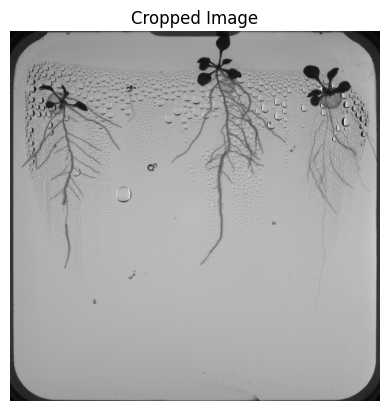

(2746, 2746)

In [8]:
# Find the petri dish
petri_dish, size = resize(image)
# Display the cropped image
plt.imshow(cv2.cvtColor(petri_dish, cv2.COLOR_BGR2RGB))
plt.title("Cropped Image")
plt.axis("off")
plt.show()
petri_dish.shape

#### Define Function for padding

In [9]:
# Define the function to predict the mask
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    # Get the height and width of the image
    h = image.shape[0]
    w = image.shape[1]
    # Calculate the amount of padding needed for both height and width
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w
    # Calculate the padding amounts for the top, bottom, left, and right sides
    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding
    # Calculate the padding amounts for the left and right sides
    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding
    # Apply the padding to the image
    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

#### Call the Padder Function and print the shape of the Padded Image

In [10]:
# Pad the petri dish
petri_dish_padded = padder(petri_dish, patch_size)
petri_dish_padded.shape

(2816, 2816)

#### The cell below patch, predict and unpatch the image so we get the predicted mask

2025-01-21 21:53:25.426344: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906


Text(0.5, 1.0, 'Prediction')

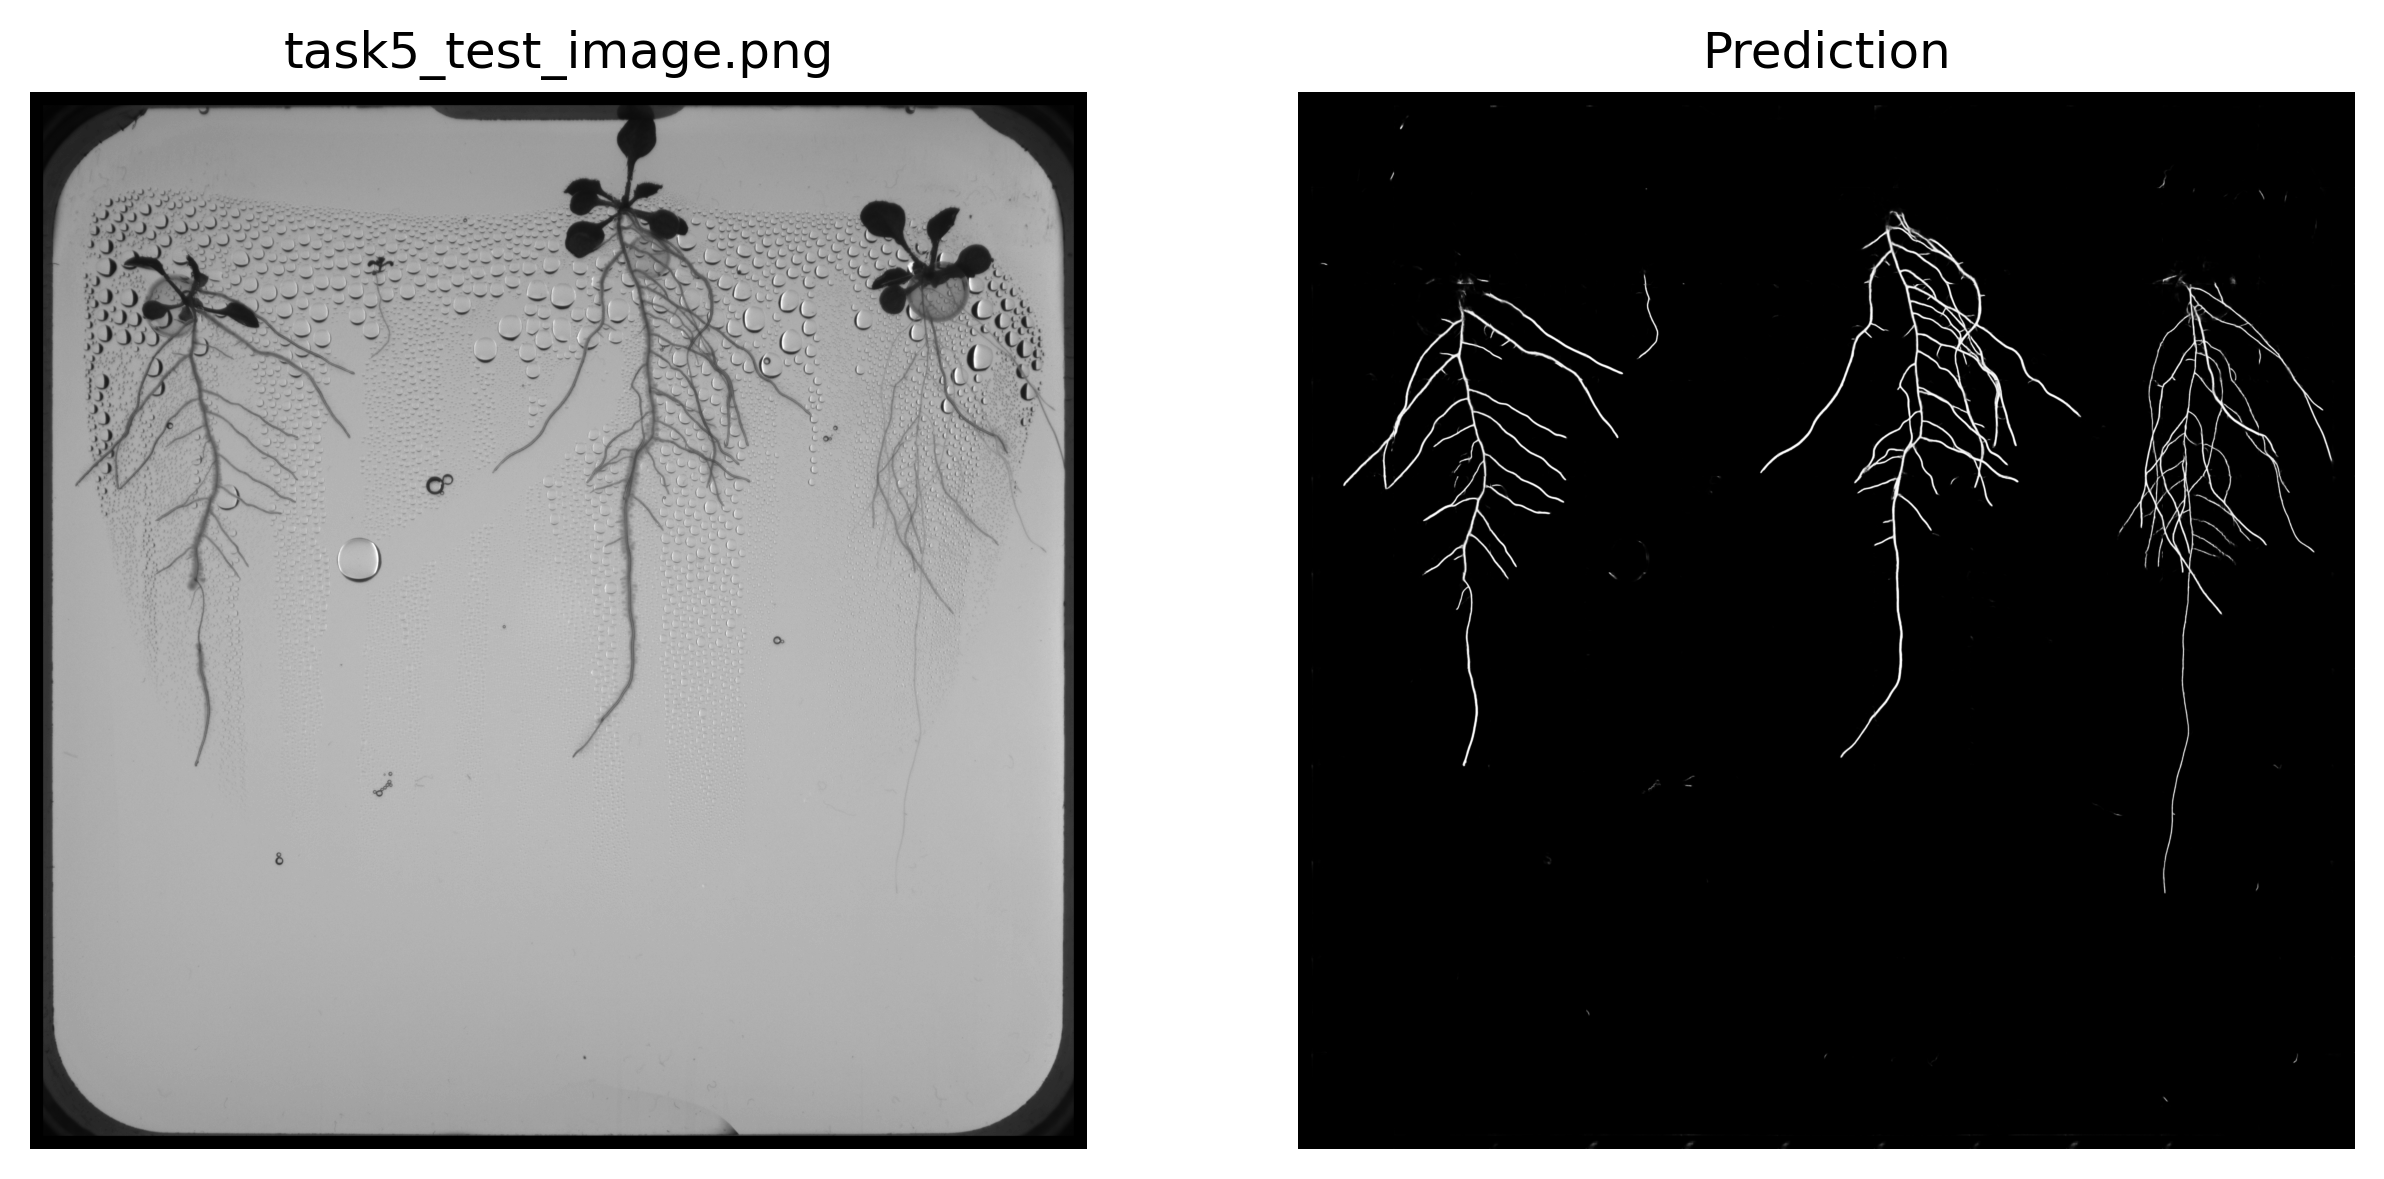

In [11]:
# Define the function to predict the mask
def predict(petri_dish_padded, patch_size):
    # PATCH
    patches = patchify(petri_dish_padded, (patch_size, patch_size), step=patch_size)
    # PREDICT
    preds_all = []
    for el in patches:
        preds = model(el/255.0)
        preds_all.append(preds)
    preds_all = np.array(preds_all)
    # UNPATCH
    predicted_mask = unpatchify(preds_all[:,:,:,:,0], (petri_dish_padded.shape[0], petri_dish_padded.shape[1]))

    return predicted_mask
# Predict the mask
predicted_mask = predict(petri_dish_padded, patch_size)
# Display the predicted mask
f, ax = plt.subplots(1, 2, dpi=300, figsize=(10, 5))
ax[0].imshow(petri_dish_padded, cmap='gray')
ax[0].axis('off')
ax[0].set_title('task5_test_image.png')
ax[1].imshow(predicted_mask, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Prediction')

In [12]:
# print the predicted mask and the original image shapes
predicted_mask.shape, image.shape

((2816, 2816), (3006, 4112))

As you can see `predicted_mask` and `image` have different shapes. This is because of cropping and padding.

**REQUIREMENT:** The input and output should have the same size and should be aligned perfectly. To achieve this, you need to reverse the effects of cropping and padding added during processing. This will ensure the final mask aligns with the original image.

#### Function that converts the mask to the size of the original image

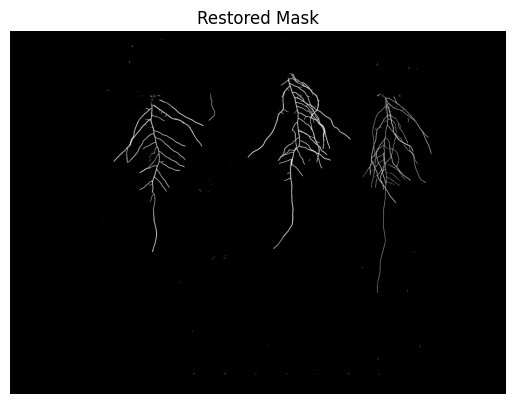

In [13]:
# Define the function to resize and position the mask
def resize_and_position_mask(predicted_mask, size, original_shape, cropped_image):
    """
    Adjusts the mask to fit the original image dimensions by placing it at the correct position.

    Args:
    - predicted_mask: Mask generated by the model (numpy array, cropped size).
    - size: Tuple containing the crop coordinates and dimensions (x_new, y_new, side_length, side_length).
    - original_shape: Shape of the original image (height, width).

    Returns:
    - restored_mask: Mask resized and positioned to fit the original image dimensions.
    """
    # Extract crop info
    x_new, y_new, side_length, side_length = size

    # Scale the mask values if necessary
    if predicted_mask.max() <= 1.0:
        predicted_mask = (predicted_mask * 255).astype(np.uint8)

    # Create a blank canvas matching the original image size
    restored_mask = np.zeros((original_shape[0], original_shape[1]), dtype=np.uint8)

    # Calculate padding for height and width
    height_diff = petri_dish_padded.shape[0] - cropped_image.shape[0]
    width_diff = petri_dish_padded.shape[1] - cropped_image.shape[1]

    top_padding = height_diff // 2
    bottom_padding = height_diff - top_padding  # Remaining goes to bottom
    left_padding = width_diff // 2
    right_padding = width_diff - left_padding  # Remaining goes to right

    # Adjust x_new and y_new
    y_new = int(y_new - top_padding)
    x_new = int(x_new - left_padding)

    # Ensure indices stay within bounds
    y_new = max(0, y_new)
    x_new = max(0, x_new)

    # Place the predicted mask into the correct position on the canvas
    restored_mask[y_new:y_new + predicted_mask.shape[0], x_new:x_new + predicted_mask.shape[1]] = predicted_mask

    return restored_mask
# Define the original image shape
original_shape = image.shape[:2]  # Height and width of the original image

# Restore the mask to the original size and position
predicted_mask_corrected = resize_and_position_mask(predicted_mask, size, original_shape, petri_dish)

# Visualize the restored mask
plt.imshow(predicted_mask_corrected, cmap='gray')
plt.axis("off")
plt.title("Restored Mask")
plt.show()

#### Check whether the corrected mask has the same shape as the input image

In [14]:
# Apply the corrections
print(predicted_mask_corrected.shape)
predicted_mask_corrected.shape == image.shape


(3006, 4112)


True

#### Define Function for Overlaying the Original image and the Corrected Mask

Text(0.5, 1.0, 'Image with Overlayed Mask')

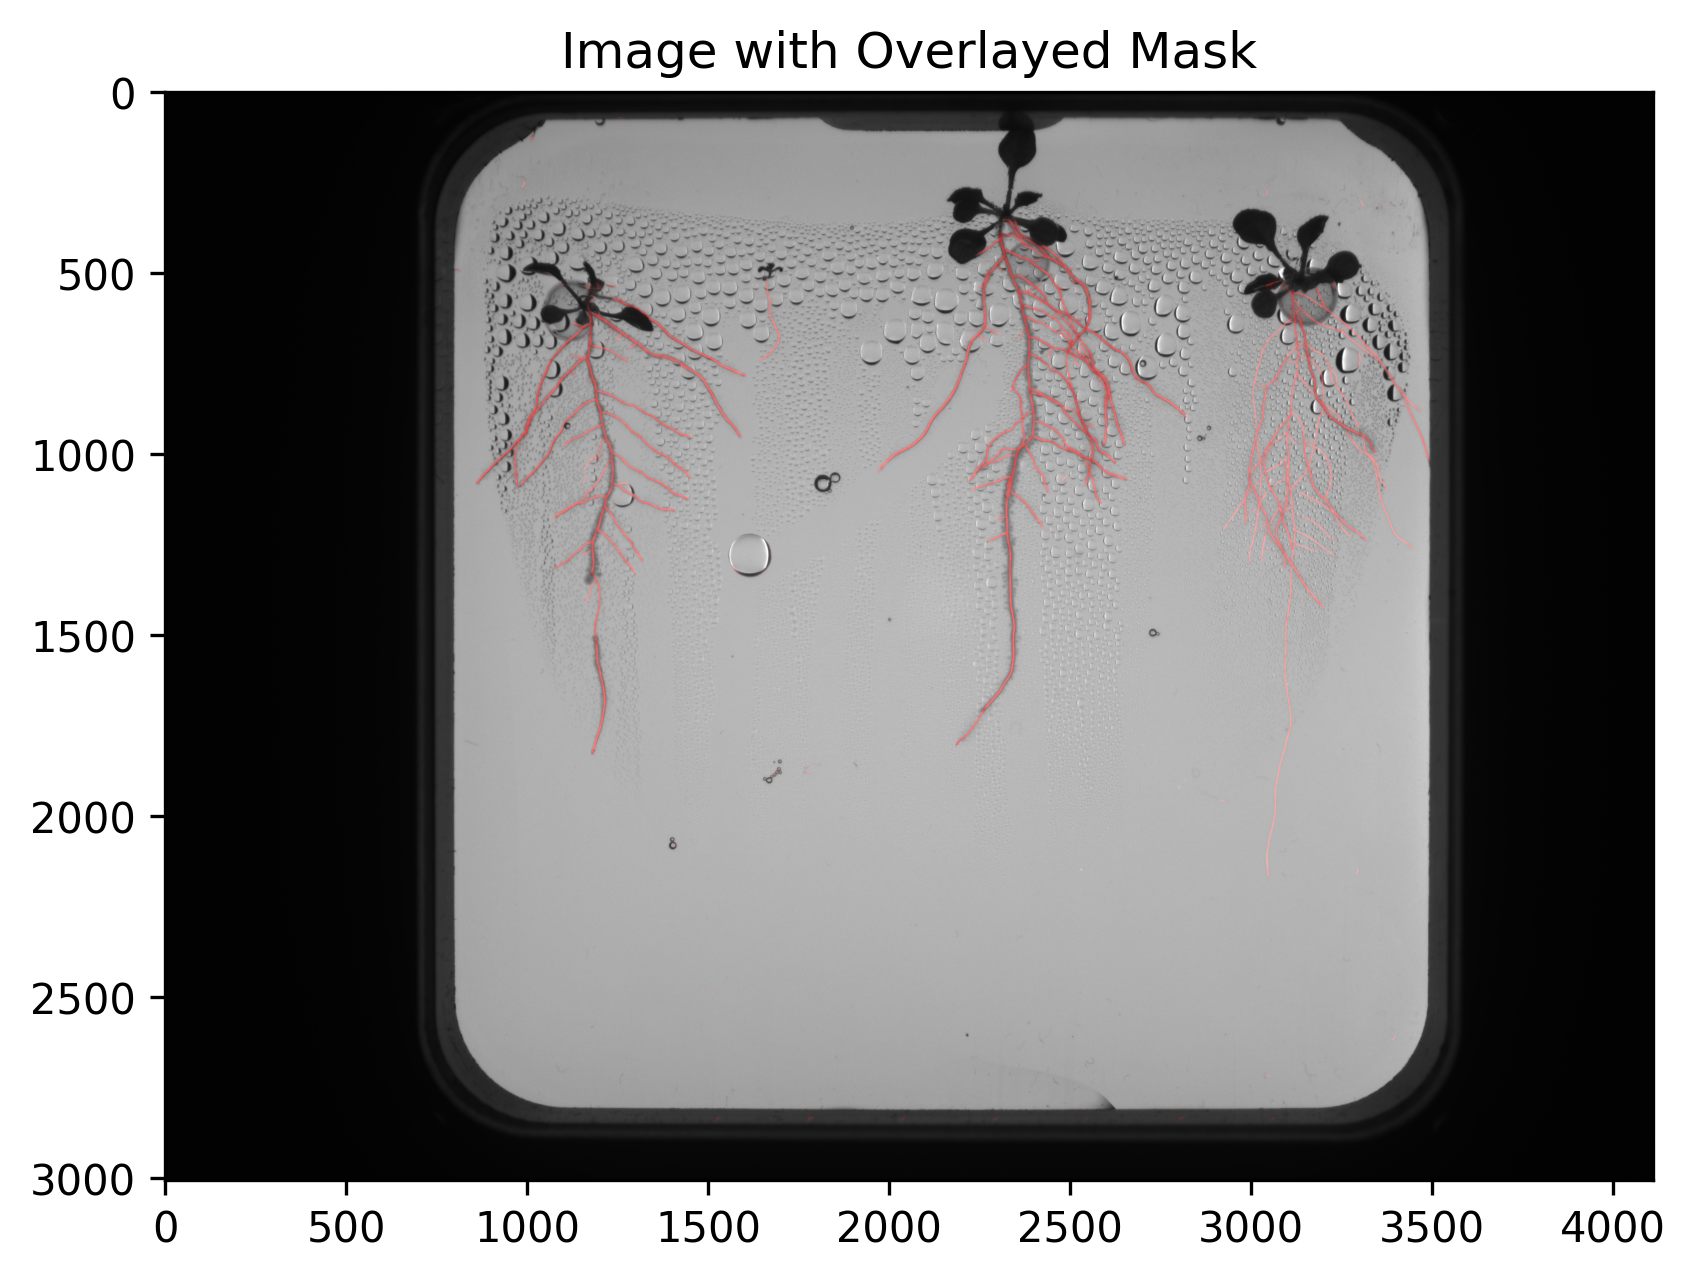

In [15]:
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: Plot such an image to prove alignment.
# function to overlay the mask on the image
def overlay_mask_on_image(image, mask):
    """
    Overlays a mask on an image, highlighting the mask in red.

    Args:
    - image: Original full-size image (numpy array, BGR format).
    - mask: Mask restored to the original size (numpy array, 2D).

    Returns:
    - combined_image: Image with the mask overlaid in red.
    """
    # Ensure the original image is a color image
    if len(image.shape) == 2:  # If grayscale, convert to BGR
        image_with_overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    else:
        image_with_overlay = np.copy(image)

    # Create a red overlay
    red_overlay = np.zeros_like(image_with_overlay)
    red_overlay[:, :, 2] = mask  # Apply the mask to the red channel

    # Combine the original image with the red overlay
    combined_image = cv2.addWeighted(image_with_overlay, 1.0, red_overlay, 0.5, 0)

    return combined_image
# Overlay на маската върху възстановеното изображение
overlay_image = overlay_mask_on_image(image, predicted_mask_corrected)

plt.figure(dpi=300)
plt.imshow(overlay_image)
plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
plt.title("Image with Overlayed Mask")

In [18]:
# REQUIREMENT: Save the predicted mask, it is a deliverable.
# REQUIREMENT: Input/Output size must be the same.
# REQUIREMENT: Predicted roots must align with the original image.
# REQUIREMENT: The predicted mask must be binary.
# REQUIREMENT: Non-root pixels must be 0, root pixels must be 255 (unlike Task 1)
# REQUIREMENT: naming convention task5_test_image_prediction_studentname_studentnumber.png
mask_image = (predicted_mask_corrected).astype(np.uint8)
assert(predicted_mask_corrected.shape == image.shape)
cv2.imwrite('task5_test_image_prediction_VladislavStoimenov_235030.png', mask_image)

True

Note: I have trained the model on the Y2B_23 dataset, since there are no labels for Y2B_24 dataset yet. The test image is from Y2B_24, this is why the predicted mask is suboptimal. Therefore do not take the performance of this prediction as a reference. Your predictions should be much better than this.

#### Loop to iterate over each image of the Kaggle dataset, use the functions and save the predicted root masks of each of them

In [16]:
import os
# Load the test images
directory = 'Kaggle'
# Create a directory to save the masks
save_directory = 'Kaggle Masks 5'
# for loop to predict the masks for all images in the directory
for filename in os.listdir(directory):
    # Load the image
    image_path = os.path.join(directory, filename)
    image = cv2.imread(image_path)
    # Convert the image to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Crop the image
    image_cropped, size = resize(image)
    # Pad the cropped image
    image_cropped_padded = padder(image_cropped, patch_size)
    # Predict the mask
    mask_predicted = predict(image_cropped_padded, patch_size)*255
    # Restore the mask
    save_path = os.path.join(save_directory, f'{filename.split(".")[0]}_root_mask.png')
    cv2.imwrite(save_path, mask_predicted)